# MNIST CNN Experiments with different kernel sizes of the conv layer

# Imports

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable
import torch.nn.utils.prune as prune

import numpy as np
import math
import cv2
import time, datetime
from prettytable import PrettyTable
from numpy.linalg import svd

In [ ]:
# Define the device to train on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load data

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 252275208.85it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 5628982.06it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 104892715.28it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21501725.47it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f9883993ca0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f9883993220>}

In [ ]:
len(loaders["test"]), len(loaders["train"])

(100, 600)

# Utils (training, testing and visualization fucntions)

In [ ]:
from torchvision.transforms.autoaugment import TrivialAugmentWide
def train(cnn, optimizer, loss_func, loaders, num_epochs):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        running_loss = 0.0
        visualize = True

        for i, (images, labels) in tqdm(enumerate(loaders['train']), total=len(loaders['train'])):
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y

            output = cnn(b_x)[0]
            b_y = b_y.to(device)
            output = output.to(device)     
            loss = loss_func(output, b_y)
            
            # clear gradients
            optimizer.zero_grad()           
            
            # backpropagation
            loss.backward()  

            optimizer.step()     

            running_loss += loss.item()     
                
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, running_loss/len(loaders['train'])))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def test(cnn, loaders):
    # Test the model
    cnn.eval()
    with torch.no_grad():
        all_labels = []
        all_preds = []
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)

            preds = torch.max(test_output, 1)[1].data.squeeze().cpu().numpy()
            labels = labels.cpu().numpy()
            
            all_labels.extend(labels)
            all_preds.extend(preds)
        
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

    # print('Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    print('Precision on the 10000 test images: %.4f' % precision)
    print('Recall on the 10000 test images: %.4f' % recall)
    print('F1 score on the 10000 test images: %.4f' % f1)

In [ ]:
def visualize_conv(conv_layer):
    fig, axs = plt.subplots(1, 2)

    k = 10
    sample_image = test_data[k]
    axs[0].imshow(sample_image[0][0], cmap='gray')

    conv_output = conv_layer(sample_image[0])
    axs[1].imshow(conv_output[0].cpu().detach().numpy(), cmap='gray')

    plt.show()

# Original CNN

## Model

In [ ]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,          
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),  
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x, visualize=False):
        # print(x.shape)
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x

In [ ]:
class MNISTCNN_kernel(nn.Module):
    def __init__(self):
        super(MNISTCNN_kernel, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=7,          
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=7,              
                stride=1,                   
                padding=2,                  
            ),  
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 5 * 5, 10)
    def forward(self, x, visualize=False):
        # print(x.shape)
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x

## Training

In [ ]:
cnn = MNISTCNN()
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:48<00:00, 12.35it/s]

Epoch [1/10], Loss: 0.1529



100%|██████████| 600/600 [00:34<00:00, 17.33it/s]

Epoch [2/10], Loss: 0.0591



100%|██████████| 600/600 [00:34<00:00, 17.16it/s]

Epoch [3/10], Loss: 0.0516



100%|██████████| 600/600 [00:33<00:00, 18.16it/s]

Epoch [4/10], Loss: 0.0457



100%|██████████| 600/600 [00:33<00:00, 17.66it/s]

Epoch [5/10], Loss: 0.0444



100%|██████████| 600/600 [00:34<00:00, 17.50it/s]

Epoch [6/10], Loss: 0.0398



100%|██████████| 600/600 [00:33<00:00, 18.07it/s]

Epoch [7/10], Loss: 0.0456



100%|██████████| 600/600 [00:33<00:00, 17.75it/s]

Epoch [8/10], Loss: 0.0355



100%|██████████| 600/600 [00:34<00:00, 17.34it/s]

Epoch [9/10], Loss: 0.0364



100%|██████████| 600/600 [00:34<00:00, 17.41it/s]

Epoch [10/10], Loss: 0.0389
Training time: 355


In [ ]:
cnn_kernel = MNISTCNN_kernel()
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_kernel.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_kernel, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:39<00:00, 15.01it/s]

Epoch [1/10], Loss: 0.1458



100%|██████████| 600/600 [00:39<00:00, 15.04it/s]

Epoch [2/10], Loss: 0.0580



100%|██████████| 600/600 [00:39<00:00, 15.12it/s]

Epoch [3/10], Loss: 0.0516



100%|██████████| 600/600 [00:39<00:00, 15.26it/s]

Epoch [4/10], Loss: 0.0450



100%|██████████| 600/600 [00:39<00:00, 15.17it/s]

Epoch [5/10], Loss: 0.0504



100%|██████████| 600/600 [00:40<00:00, 14.98it/s]

Epoch [6/10], Loss: 0.0460



100%|██████████| 600/600 [00:39<00:00, 15.37it/s]

Epoch [7/10], Loss: 0.0494



100%|██████████| 600/600 [00:39<00:00, 15.28it/s]

Epoch [8/10], Loss: 0.0453



100%|██████████| 600/600 [00:39<00:00, 15.18it/s]

Epoch [9/10], Loss: 0.0465



100%|██████████| 600/600 [00:39<00:00, 15.29it/s]

Epoch [10/10], Loss: 0.0387
Training time: 395


## Testing

In [ ]:
test(cnn, loaders)

Precision on the 10000 test images: 0.9875
Recall on the 10000 test images: 0.9874
F1 score on the 10000 test images: 0.9874


In [ ]:
test(cnn_kernel, loaders)

Precision on the 10000 test images: 0.9819
Recall on the 10000 test images: 0.9818
F1 score on the 10000 test images: 0.9818


# CNN with fractional filters

## Model

In [ ]:
class FractionalConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(FractionalConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Initializing the learnable parameters

        # In A < 1, because the gamma function is not defined for negative integers or zero.
        # In the paper, they mention using a regularization term 
        # to ensure that A is greater than or equal to 1, which would avoid this issue.
        self.A = torch.randn(self.out_channels, self.in_channels)
        self.A = nn.Parameter(torch.abs(self.A) + 1)

        self.sigma = nn.Parameter(torch.randn(self.out_channels, self.in_channels).abs())
        self.x0 = nn.Parameter(torch.randn(self.out_channels, self.in_channels))
        self.y0 = nn.Parameter(torch.randn(self.out_channels, self.in_channels))
        self.a = nn.Parameter(torch.rand(self.out_channels, self.in_channels) * 2)
        self.b = nn.Parameter(torch.rand(self.out_channels, self.in_channels) * 2)

        self.weights = None
        self.compute_weights()

    def compute_weights(self):
        # Computing weights
        weights = torch.zeros(self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
        dx = self._fractional_derivative(self.a, self.A, self.sigma, self.x0)
        dy = self._fractional_derivative(self.a, self.A, self.sigma, self.y0)

        kernel = torch.einsum('abc,abd->acbd', dx, dy)
        weights = kernel.reshape(dx.shape[0], dx.shape[1], dx.shape[2], dy.shape[2])

        self.weights = weights.to(device)

    def forward(self, x):
        self.weights = self.weights.clone().detach()
        x = x.to(device)
        out = F.conv2d(x, self.weights, stride=self.stride, padding=self.padding)
        return out

    def _fractional_derivative(self, alpha, A, sigma, x0):
        N = 10
        h = torch.tensor(1 / self.kernel_size).repeat(self.out_channels, self.in_channels, self.kernel_size)

        def gamma_func(a):
            return torch.exp(torch.lgamma(a))

        def G(x):
            return torch.exp(-(torch.square(x-x0))/torch.square(sigma))
        
        def f(x, n):
            return (gamma_func(alpha + 1) * G(x)) / ((-1)**n * gamma_func(n+1) * gamma_func(1-n+alpha))

        dx = torch.zeros (self.out_channels, self.in_channels, self.kernel_size)
        for x in range(1, self.kernel_size+1):
            x = torch.tensor(x).repeat(self.out_channels, self.in_channels)
            sum_term = 0
            for n in range(N+1):
                n = torch.tensor(n).repeat(self.out_channels, self.in_channels)
                sum_term += f(x, n)

            dx[..., x-1] = sum_term

        dx = dx.to(device)
        h = h.to(device)
        A = A.unsqueeze(2).repeat(1, 1, self.kernel_size)
        A = A.to(device)
        dx = (A / h) * dx

        return dx

In [ ]:
class MNISTCNN_frac(nn.Module):
    def __init__(self):
        super(MNISTCNN_frac, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,          
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(
            FractionalConv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,           
                stride=1,                   
                padding=2,                  
            ),    
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10).to(device)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        x.to(device)
        output = self.out(x)
        return output, x

In [ ]:
class MNISTCNN_frac_kernel(nn.Module):
    def __init__(self):
        super(MNISTCNN_frac_kernel, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=7,         
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(
            FractionalConv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=7,           
                stride=1,                   
                padding=2,                  
            ),    
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 5 * 5, 10).to(device)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        x.to(device)
        output = self.out(x)
        return output, x

## Training

In [ ]:
cnn_frac = MNISTCNN_frac()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_frac.parameters(), lr = 0.01)   

start = datetime.datetime.now()
train(cnn_frac, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:18<00:00, 31.75it/s]

Epoch [1/10], Loss: 0.6341



100%|██████████| 600/600 [00:20<00:00, 29.91it/s]

Epoch [2/10], Loss: 0.4011



100%|██████████| 600/600 [00:19<00:00, 31.22it/s]

Epoch [3/10], Loss: 0.3458



100%|██████████| 600/600 [00:19<00:00, 30.77it/s]

Epoch [4/10], Loss: 0.3057



100%|██████████| 600/600 [00:19<00:00, 30.41it/s]

Epoch [5/10], Loss: 0.2762



100%|██████████| 600/600 [00:18<00:00, 31.90it/s]

Epoch [6/10], Loss: 0.2481



100%|██████████| 600/600 [00:20<00:00, 29.43it/s]

Epoch [7/10], Loss: 0.2217



100%|██████████| 600/600 [00:18<00:00, 32.15it/s]

Epoch [8/10], Loss: 0.2083



100%|██████████| 600/600 [00:20<00:00, 29.45it/s]

Epoch [9/10], Loss: 0.1899



100%|██████████| 600/600 [00:19<00:00, 30.74it/s]

Epoch [10/10], Loss: 0.1750
Training time: 195


In [ ]:
cnn_frac_kernel = MNISTCNN_frac_kernel()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_frac_kernel.parameters(), lr = 0.01)   

start = datetime.datetime.now()
train(cnn_frac_kernel, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:23<00:00, 25.74it/s]

Epoch [1/10], Loss: 2.3096



100%|██████████| 600/600 [00:23<00:00, 25.79it/s]

Epoch [2/10], Loss: 2.3020



100%|██████████| 600/600 [00:23<00:00, 25.71it/s]

Epoch [3/10], Loss: 2.3020



100%|██████████| 600/600 [00:23<00:00, 25.84it/s]

Epoch [4/10], Loss: 2.3020



100%|██████████| 600/600 [00:23<00:00, 25.88it/s]

Epoch [5/10], Loss: 2.3018



100%|██████████| 600/600 [00:23<00:00, 25.37it/s]

Epoch [6/10], Loss: 2.3016



100%|██████████| 600/600 [00:22<00:00, 26.92it/s]

Epoch [7/10], Loss: 2.2999



100%|██████████| 600/600 [00:23<00:00, 25.82it/s]

Epoch [8/10], Loss: 2.2958



100%|██████████| 600/600 [00:23<00:00, 25.01it/s]

Epoch [9/10], Loss: 2.2865



100%|██████████| 600/600 [00:23<00:00, 25.06it/s]

Epoch [10/10], Loss: 2.2678
Training time: 233


## Testing

In [ ]:
test(cnn_frac, loaders)

Precision on the 10000 test images: 0.9536
Recall on the 10000 test images: 0.9533
F1 score on the 10000 test images: 0.9532


In [ ]:
test(cnn_frac_kernel, loaders)

Precision on the 10000 test images: 0.9573
Recall on the 10000 test images: 0.9562
F1 score on the 10000 test images: 0.9562


# CNN with pruning

## Model

In [ ]:
class PrunedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True, sparsity=0.5):
        super(PrunedConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.sparsity = sparsity

        self.prune()

    def forward(self, x):
        return self.conv(x)

    def prune(self):
        prune.random_unstructured(self.conv, name="weight", amount=0.3)

    def get_sparsity(self):
        return self.sparsity

    def set_sparsity(self, sparsity):
        self.sparsity = sparsity
        self.prune()

In [ ]:
class MNISTCNN_pruned(nn.Module):
    def __init__(self):
        super(MNISTCNN_pruned, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,          
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(
            PrunedConv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,             
                stride=1,                   
                padding=2,                  
            ),  
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x

In [ ]:
class MNISTCNN_pruned_kernel(nn.Module):
    def __init__(self):
        super(MNISTCNN_pruned_kernel, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=7,          
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(
            PrunedConv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=7,             
                stride=1,                   
                padding=2,                  
            ),  
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 5 * 5, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x

## Training

In [ ]:
cnn_pruned = MNISTCNN_pruned()
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_pruned.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_pruned, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:44<00:00, 13.36it/s]

Epoch [1/10], Loss: 0.1517



100%|██████████| 600/600 [00:34<00:00, 17.61it/s]

Epoch [2/10], Loss: 0.0603



100%|██████████| 600/600 [00:36<00:00, 16.61it/s]

Epoch [3/10], Loss: 0.0488



100%|██████████| 600/600 [00:35<00:00, 16.82it/s]

Epoch [4/10], Loss: 0.0490



100%|██████████| 600/600 [00:35<00:00, 16.73it/s]

Epoch [5/10], Loss: 0.0428



100%|██████████| 600/600 [00:35<00:00, 16.88it/s]

Epoch [6/10], Loss: 0.0405



100%|██████████| 600/600 [00:35<00:00, 16.97it/s]

Epoch [7/10], Loss: 0.0417



100%|██████████| 600/600 [00:36<00:00, 16.59it/s]

Epoch [8/10], Loss: 0.0379



100%|██████████| 600/600 [00:36<00:00, 16.38it/s]

Epoch [9/10], Loss: 0.0386



100%|██████████| 600/600 [00:35<00:00, 16.69it/s]

Epoch [10/10], Loss: 0.0323
Training time: 366


In [ ]:
cnn_pruned_kernel = MNISTCNN_pruned_kernel()
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_pruned_kernel.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_pruned_kernel, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

100%|██████████| 600/600 [00:41<00:00, 14.47it/s]

Epoch [1/10], Loss: 0.1523



100%|██████████| 600/600 [00:41<00:00, 14.53it/s]

Epoch [2/10], Loss: 0.0669



100%|██████████| 600/600 [00:41<00:00, 14.57it/s]

Epoch [3/10], Loss: 0.0519



100%|██████████| 600/600 [00:41<00:00, 14.59it/s]

Epoch [4/10], Loss: 0.0484



100%|██████████| 600/600 [00:40<00:00, 14.99it/s]

Epoch [5/10], Loss: 0.0457



100%|██████████| 600/600 [00:40<00:00, 14.83it/s]

Epoch [6/10], Loss: 0.0506



100%|██████████| 600/600 [00:40<00:00, 14.84it/s]

Epoch [7/10], Loss: 0.0441



100%|██████████| 600/600 [00:41<00:00, 14.58it/s]

Epoch [8/10], Loss: 0.0454



100%|██████████| 600/600 [00:41<00:00, 14.29it/s]

Epoch [9/10], Loss: 0.0463



100%|██████████| 600/600 [00:41<00:00, 14.55it/s]

Epoch [10/10], Loss: 0.0474
Training time: 410


## Testing

In [ ]:
test(cnn_pruned, loaders)

Precision on the 10000 test images: 0.9838
Recall on the 10000 test images: 0.9836
F1 score on the 10000 test images: 0.9836


In [ ]:
test(cnn_pruned_kernel, loaders)

Precision on the 10000 test images: 0.9831
Recall on the 10000 test images: 0.9830
F1 score on the 10000 test images: 0.9830


## Visualization

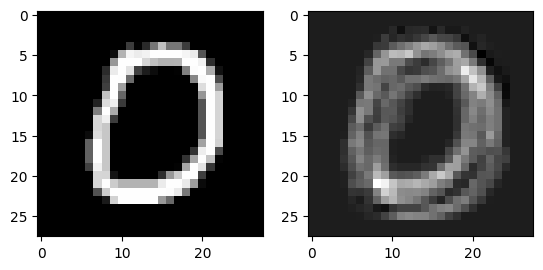

In [ ]:
pruned_conv_layer = PrunedConv2d(
                in_channels=1,              
                out_channels=1,      
                kernel_size=5,       
                stride=1,                   
                padding=2,                  
            )
visualize_conv(pruned_conv_layer)

# CNN with Low-rank approximation

## Model

In [ ]:
class LowRankConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, r=3, method='constant', decomposition='cur'):
        super(LowRankConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.r = r

        self.conv = nn.Conv2d(
                in_channels=self.in_channels,              
                out_channels=self.out_channels,            
                kernel_size=self.kernel_size,           
                stride=self.stride,                   
                padding=self.padding,                  
            )
        # print(self.conv.weight.shape)
        
        if decomposition == 'cur':
            if method == 'constant':
                c = 0.99
            elif method == 'log':
                c = np.log(self.conv.weight.shape[-1])
            self.conv.weight.data = torch.from_numpy(self.cur_low_rank(self.conv.weight, c=c, r=r))
        elif decomposition == 'svd':
            self.conv.weight.data = torch.from_numpy(self.traditional_low_rank(self.conv.weight, r=r))

        # print(self.conv.weight.shape)

    def forward(self, x):
        return self.conv(x)

    def traditional_low_rank(self, A, r):
        # A is a 4D weight matrix
        # k is the target rank
        A = A.detach().numpy()
        
        # Flatten the 4D weight matrix into a 2D matrix
        n1, n2, n3, n4 = A.shape
        A = A.reshape((n1*n2*n3, n4))
        print(f"A before approx: {np.linalg.matrix_rank(A)}, {A.shape}")

        # Compute the SVD of A
        U, s, Vt = svd(A, full_matrices=False)

        # print(U.shape, s.shape, Vt.shape)

        # Truncate the SVD to the target rank
        U = U[:, :r]
        s = s[:r]
        Vt = Vt[:r, :]

        # print(U.shape, s.shape, Vt.shape)

        # Compute the low-rank approximation
        A_approx = np.dot(U, np.dot(np.diag(s), Vt))
        # A_approx = U @ s @ Vt

        print(f"A after approx: {np.linalg.matrix_rank(A_approx)}, {A_approx.shape}")

        # Reshape the low-rank approximation to a 4D weight matrix
        A_approx = A_approx.reshape((n1, n2, n3, n4))

        return A_approx

    def cur_low_rank(self, A, c, r):
        # Flatten the 4D weight matrix into a 2D matrix
        A = A.detach().numpy()
        n1, n2, n3, n4 = A.shape
        A_2d = A.reshape((n1*n2*n3, n4))
        m, n = A_2d.shape
        print(f"A before approx: {np.linalg.matrix_rank(A_2d)}")

        curr_r = np.linalg.matrix_rank(A_2d)
        
        # Computing C
        def choose_col_by_prob(A):
            U, s, Vt = svd(A, full_matrices=False)

            leverage_scores = np.linalg.norm(Vt[:curr_r], axis=0) ** 2 / curr_r
            column_probabilities = np.minimum(c, leverage_scores) / np.sum(np.minimum(c, leverage_scores))
            selected_columns = np.random.choice(A.shape[1], curr_r, replace=False, p=column_probabilities)
            
            return A[:, selected_columns]

        C = choose_col_by_prob(A_2d)
        R = choose_col_by_prob(np.transpose(A_2d))
        C_pinv = np.linalg.pinv(C)
        R_pinv = np.linalg.pinv(R)

        U = C_pinv @ A_2d @ R_pinv

        # print(C.shape, U.shape, R.shape)
        # Truncate the CUR to the target rank
        C = C[:, :r]
        U = U[:r, :r]
        R = R[:r, :]

        A_approx = C @ U @ R

        print(f"A after approx: {np.linalg.matrix_rank(A_approx)}")

        # Reshape the low-rank approximation to a 4D weight matrix
        A_approx = A_approx.reshape((n1, n2, n3, n4))
        return A_approx

In [ ]:
class MNISTCNN_lowrank(nn.Module):
    def __init__(self, r=3, method='constant', decomposition='cur'):
        super(MNISTCNN_lowrank, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,          
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(
            LowRankConv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,             
                stride=1,                   
                padding=2, 
                r=r,
                method=method,
                decomposition = decomposition                
            ),  
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x

In [ ]:
class MNISTCNN_lowrank_kernel(nn.Module):
    def __init__(self, r=3, method='constant', decomposition='cur'):
        super(MNISTCNN_lowrank_kernel, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=7,          
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(
            LowRankConv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=7,             
                stride=1,                   
                padding=2, 
                r=r,
                method=method,
                decomposition = decomposition                
            ),  
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 5 * 5, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x

## Training

In [ ]:
cnn_lowrank = MNISTCNN_lowrank(r=3, method='log', decomposition='cur')
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_lowrank.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_lowrank, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

A before approx: 5
A after approx: 3


100%|██████████| 600/600 [00:24<00:00, 24.05it/s]

Epoch [1/10], Loss: 0.1826



100%|██████████| 600/600 [00:24<00:00, 24.01it/s]

Epoch [2/10], Loss: 0.0577



100%|██████████| 600/600 [00:24<00:00, 24.06it/s]

Epoch [3/10], Loss: 0.0503



100%|██████████| 600/600 [00:24<00:00, 24.05it/s]

Epoch [4/10], Loss: 0.0444



100%|██████████| 600/600 [00:25<00:00, 23.97it/s]

Epoch [5/10], Loss: 0.0412



100%|██████████| 600/600 [00:24<00:00, 24.07it/s]

Epoch [6/10], Loss: 0.0375



100%|██████████| 600/600 [00:24<00:00, 24.43it/s]

Epoch [7/10], Loss: 0.0392



100%|██████████| 600/600 [00:24<00:00, 24.21it/s]

Epoch [8/10], Loss: 0.0360



100%|██████████| 600/600 [00:24<00:00, 24.43it/s]

Epoch [9/10], Loss: 0.0369



100%|██████████| 600/600 [00:24<00:00, 24.27it/s]

Epoch [10/10], Loss: 0.0327
Training time: 248


In [ ]:
cnn_lowrank_kernel = MNISTCNN_lowrank_kernel(r=3, method='log', decomposition='cur')
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn_lowrank_kernel.parameters(), lr = 0.01)   


start = datetime.datetime.now()
train(cnn_lowrank_kernel, optimizer, loss_func, loaders, num_epochs=10)
end = datetime.datetime.now()
diff = (end - start)
print("Training time:", int(diff.total_seconds()))

A before approx: 7
A after approx: 3


100%|██████████| 600/600 [00:25<00:00, 23.61it/s]

Epoch [1/10], Loss: 0.1340



100%|██████████| 600/600 [00:25<00:00, 23.51it/s]

Epoch [2/10], Loss: 0.0593



100%|██████████| 600/600 [00:25<00:00, 23.72it/s]

Epoch [3/10], Loss: 0.0518



100%|██████████| 600/600 [00:25<00:00, 23.59it/s]

Epoch [4/10], Loss: 0.0444



100%|██████████| 600/600 [00:25<00:00, 23.75it/s]

Epoch [5/10], Loss: 0.0466



100%|██████████| 600/600 [00:25<00:00, 23.34it/s]

Epoch [6/10], Loss: 0.0448



100%|██████████| 600/600 [00:25<00:00, 23.58it/s]

Epoch [7/10], Loss: 0.0508



100%|██████████| 600/600 [00:25<00:00, 23.47it/s]

Epoch [8/10], Loss: 0.0486



100%|██████████| 600/600 [00:25<00:00, 23.49it/s]

Epoch [9/10], Loss: 0.0474



100%|██████████| 600/600 [00:25<00:00, 23.46it/s]

Epoch [10/10], Loss: 0.0497
Training time: 255


## Testing

In [ ]:
test(cnn_lowrank, loaders)

Precision on the 10000 test images: 0.9851
Recall on the 10000 test images: 0.9851
F1 score on the 10000 test images: 0.9851


In [ ]:
test(cnn_lowrank_kernel, loaders)

Precision on the 10000 test images: 0.9843
Recall on the 10000 test images: 0.9842
F1 score on the 10000 test images: 0.9842


# Count parameters for all

In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
cnn_params = count_parameters(cnn)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| conv1.0.weight |    400     |
|  conv1.0.bias  |     16     |
| conv2.0.weight |   12800    |
|  conv2.0.bias  |     32     |
|   out.weight   |   15680    |
|    out.bias    |     10     |
+----------------+------------+
Total Trainable Params: 28938


In [ ]:
cnn_params = count_parameters(cnn_kernel)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| conv1.0.weight |    784     |
|  conv1.0.bias  |     16     |
| conv2.0.weight |   25088    |
|  conv2.0.bias  |     32     |
|   out.weight   |    8000    |
|    out.bias    |     10     |
+----------------+------------+
Total Trainable Params: 33930


In [ ]:
cnn_frac_params = count_parameters(cnn_frac)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| conv1.0.weight |    400     |
|  conv1.0.bias  |     16     |
|   conv2.0.A    |    512     |
| conv2.0.sigma  |    512     |
|   conv2.0.x0   |    512     |
|   conv2.0.y0   |    512     |
|   conv2.0.a    |    512     |
|   conv2.0.b    |    512     |
|   out.weight   |   15680    |
|    out.bias    |     10     |
+----------------+------------+
Total Trainable Params: 19178


In [ ]:
cnn_frac_params = count_parameters(cnn_frac_kernel)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| conv1.0.weight |    784     |
|  conv1.0.bias  |     16     |
|   conv2.0.A    |    512     |
| conv2.0.sigma  |    512     |
|   conv2.0.x0   |    512     |
|   conv2.0.y0   |    512     |
|   conv2.0.a    |    512     |
|   conv2.0.b    |    512     |
|   out.weight   |    8000    |
|    out.bias    |     10     |
+----------------+------------+
Total Trainable Params: 11882


In [ ]:
from prettytable import PrettyTable

def count_parameters_pruning(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        
        param = parameter.numel()
        if 'conv2.0.conv.weight' in name:
            pruned_mask = list(model.conv2.named_buffers())
            param = int(torch.sum(pruned_mask[0][1]).item())
            name = name[:-5]
        
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


In [ ]:
cnn_pruned_params = count_parameters_pruning(cnn_pruned)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|    conv1.0.weight   |    400     |
|     conv1.0.bias    |     16     |
|  conv2.0.conv.bias  |     32     |
| conv2.0.conv.weight |    8960    |
|      out.weight     |   15680    |
|       out.bias      |     10     |
+---------------------+------------+
Total Trainable Params: 25098


In [ ]:
cnn_pruned_kernel_params = count_parameters_pruning(cnn_pruned_kernel)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|    conv1.0.weight   |    784     |
|     conv1.0.bias    |     16     |
|  conv2.0.conv.bias  |     32     |
| conv2.0.conv.weight |   17562    |
|      out.weight     |    8000    |
|       out.bias      |     10     |
+---------------------+------------+
Total Trainable Params: 26404
